## Installation of libraries and imports

In [ ]:
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 10.3 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 48.8 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import copy
import torch.optim as optim
import random
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup
from datasets import load_dataset, load_metric
from sklearn import metrics
import transformers

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
# Check that we are using 100% of GPU memory footprint support libraries/code
# from https://github.com/patrickvonplaten/notebooks/blob/master/PyTorch_Reformer.ipynb
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip -q install gputil
!pip -q install psutil
!pip -q install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Preparing metadata (setup.py) ... done
Gen RAM Free: 11.8 GB  | Proc size: 767.1 MB
GPU RAM Free: 15109MB | Used: 0MB | Util   0% | Total 15360MB


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading the dataset

In [ ]:
import pandas as pd


In [ ]:
# Transform data into pandas dataframes
df_train = pd.read_csv('/content/drive/MyDrive/data/train_data.csv')
df_val = pd.read_csv('/content/drive/MyDrive/data/val_data.csv')
df_test = pd.read_csv('/content/drive/MyDrive/data/test_data.csv')

In [ ]:
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(80199, 6)
(9931, 6)
(9919, 6)


In [ ]:
perc = df_train["label"].value_counts(normalize=True)
print(perc)

0    0.604533
1    0.395467
Name: label, dtype: float64


In [ ]:
perc = df_test["label"].value_counts(normalize=True)
print(perc)

0    0.584837
1    0.415163
Name: label, dtype: float64


In [ ]:
perc = df_val["label"].value_counts(normalize=True)
print(perc)

0    0.584835
1    0.415165
Name: label, dtype: float64


In [ ]:
df_train.head()

,text_id,source,target,sentence_id,sentence,label
0,1,august is the eighth month of the year in the ...,august ( aug. ) is the eighth month of the yea...,0,august is the eighth month of the year in the ...,1
1,1,august is the eighth month of the year in the ...,august ( aug. ) is the eighth month of the yea...,1,it was originally named `` sextilis '' in lati...,1
2,1,august is the eighth month of the year in the ...,august ( aug. ) is the eighth month of the yea...,2,"about 700 bc , it became the eighth month when...",0
3,1,august is the eighth month of the year in the ...,august ( aug. ) is the eighth month of the yea...,3,julius caesar added two days when he created t...,1
4,1,august is the eighth month of the year in the ...,august ( aug. ) is the eighth month of the yea...,4,"in 8 bc , it was renamed in honor of augustus .",0


In [ ]:
df_train = df_train.sample(frac = 1)

In [ ]:
df_train.head()

,text_id,source,target,sentence_id,sentence,label
567,53,"china ( ) , officially the people 's republic ...",china ( pinyin : zhΕ�ngguΓ³ ) is a cultural re...,18,political dissidents and human rights groups h...,0
268,25,"austria ( , ; ) , officially the republic of a...",austria ( ; officially called republic of aust...,6,"in the 16th century , austria started serving ...",0
56876,6506,"a concerto ( ; plural `` concertos '' , or `` ...",a concerto is a piece of music made for a solo...,2,"presto or allegro ) , became a standard from t...",0
6086,619,ulster ( ; or `` cΓΊige uladh '' ; or `` ulste...,ulster is one of the four historical provinces...,12,after the norman invasion of ireland in the 12...,0
62707,7308,"vojvodina ( , ; pannonian rusyn : ; , ; ) , of...",the autonomous province of vojvodina ( serbian...,1,novi sad is the largest city and administrativ...,1


In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
# Concatenate train data and test data
all_sentences = np.concatenate([df_train.sentence.values, df_test.sentence.values])

# Encode our concatenated data
encoded_sentences = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_sentences]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_sentences])
print('Max length: ', max_len)

Max length:  276


In [ ]:
import seaborn as sns

In [ ]:
df = pd.DataFrame({0: encoded_sentences})

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


Minimum word count required to include all words in 95.0% of the reviews: 61.0


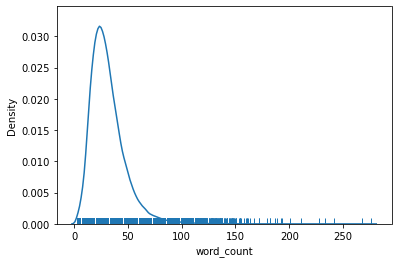

In [ ]:
df.head()

df_stat = df.copy()
df_stat['word_count'] = df[0].apply(lambda txt: len(txt))
#print(df_stat.head())

q=0.95
x = df_stat['word_count']
sns.distplot(x, hist=False, rug=True);
print('Minimum word count required to include all words in {}% of the reviews: {}'.format(q*100, x.quantile(q)))

## Classes and functions

In [ ]:
class CustomDataset(Dataset):

    def __init__(self, data, maxlen, with_labels=True, bert_model='bert-base-uncased'):

        self.data = data  # pandas dataframe
        #Initialize the tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(bert_model)

        self.maxlen = maxlen
        self.with_labels = with_labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):

        # Selecting sentence1 and sentence2 at the specified index in the data frame
        sent1 = str(self.data.loc[index, 'sentence'])
        #sent2 = str(self.data.loc[index, 'source'])

        # Tokenize the pair of sentences to get token ids, attention masks and token type ids
        encoded_pair = self.tokenizer(sent1,
                                      padding='max_length',  # Pad to max_length
                                      truncation=True,  # Truncate to max_length
                                      max_length=self.maxlen,
                                      return_tensors='pt')  # Return torch.Tensor objects

        token_ids = encoded_pair['input_ids'].squeeze(0)  # tensor of token ids
        attn_masks = encoded_pair['attention_mask'].squeeze(0)  # binary tensor with "0" for padded values and "1" for the other values
        token_type_ids = encoded_pair['token_type_ids'].squeeze(0)  # binary tensor with "0" for the 1st sentence tokens & "1" for the 2nd sentence tokens

        if self.with_labels:  # True if the dataset has labels
            label = self.data.loc[index, 'label']
            return token_ids, attn_masks, token_type_ids, label
        else:
            return token_ids, attn_masks, token_type_ids

In [ ]:
class SentencePairClassifier(nn.Module):

    def __init__(self, bert_model="bert-base-uncased", freeze_bert=False):
        super(SentencePairClassifier, self).__init__()
        #  Instantiating BERT-based model object
        self.bert_layer = AutoModel.from_pretrained(bert_model, return_dict=False)

        #  Fix the hidden-state size of the encoder outputs (If you want to add other pre-trained models here, search for the encoder output size)
        if bert_model == "albert-base-v2":  # 12M parameters
            hidden_size = 768
        elif bert_model == "albert-large-v2":  # 18M parameters
            hidden_size = 1024
        elif bert_model == "albert-xlarge-v2":  # 60M parameters
            hidden_size = 2048
        elif bert_model == "albert-xxlarge-v2":  # 235M parameters
            hidden_size = 4096
        elif bert_model == "bert-base-uncased": # 110M parameters
            hidden_size = 768

        # Freeze bert layers and only train the classification layer weights
        if freeze_bert:
            for p in self.bert_layer.parameters():
                p.requires_grad = False

        # Classification layer
        self.cls_layer = nn.Linear(hidden_size, 1)

        self.dropout = nn.Dropout(p=0.1)

    @autocast()  # run in mixed precision
    def forward(self, input_ids, attn_masks, token_type_ids):
        '''
        Inputs:
            -input_ids : Tensor  containing token ids
            -attn_masks : Tensor containing attention masks to be used to focus on non-padded values
            -token_type_ids : Tensor containing token type ids to be used to identify sentence1 and sentence2
        '''

        # Feeding the inputs to the BERT-based model to obtain contextualized representations
        cont_reps, pooler_output = self.bert_layer(input_ids, attn_masks, token_type_ids)

        # Feeding to the classifier layer the last layer hidden-state of the [CLS] token further processed by a
        # Linear Layer and a Tanh activation. The Linear layer weights were trained from the sentence order prediction (ALBERT) or next sentence prediction (BERT)
        # objective during pre-training.
        logits = self.cls_layer(self.dropout(pooler_output))

        return logits

In [ ]:
def set_seed(seed):
    """ Set all seeds to make results reproducible """
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)


def evaluate_loss(net, device, criterion, dataloader):
    net.eval()

    mean_loss = 0
    count = 0

    with torch.no_grad():
        for it, (seq, attn_masks, token_type_ids, labels) in enumerate(tqdm(dataloader)):
            seq, attn_masks, token_type_ids, labels = \
                seq.to(device), attn_masks.to(device), token_type_ids.to(device), labels.to(device)
            logits = net(seq, attn_masks, token_type_ids)
            mean_loss += criterion(logits.squeeze(-1), labels.float()).item()
            count += 1

    return mean_loss / count

In [ ]:
print("Creation of the models' folder...")
!mkdir models

Creation of the models' folder...


In [ ]:
def train_bert(net, criterion, opti, lr, lr_scheduler, train_loader, val_loader, epochs, iters_to_accumulate):

    best_loss = np.Inf
    best_ep = 1
    nb_iterations = len(train_loader)
    print_every = nb_iterations // 5  # print the training loss 5 times per epoch
    iters = []
    train_losses = []
    val_losses = []

    scaler = GradScaler()

    for ep in range(epochs):

        net.train()
        running_loss = 0.0
        for it, (seq, attn_masks, token_type_ids, labels) in enumerate(tqdm(train_loader)):

            # Converting to cuda tensors
            seq, attn_masks, token_type_ids, labels = \
                seq.to(device), attn_masks.to(device), token_type_ids.to(device), labels.to(device)

            # Enables autocasting for the forward pass (model + loss)
            with autocast():
                # Obtaining the logits from the model
                logits = net(seq, attn_masks, token_type_ids)

                # Computing loss
                loss = criterion(logits.squeeze(-1), labels.float())
                loss = loss / iters_to_accumulate  # Normalize the loss because it is averaged

            # Backpropagating the gradients
            # Scales loss.  Calls backward() on scaled loss to create scaled gradients.
            scaler.scale(loss).backward()

            if (it + 1) % iters_to_accumulate == 0:
                # Optimization step
                # scaler.step() first unscales the gradients of the optimizer's assigned params.
                # If these gradients do not contain infs or NaNs, opti.step() is then called,
                # otherwise, opti.step() is skipped.
                scaler.step(opti)
                # Updates the scale for next iteration.
                scaler.update()
                # Adjust the learning rate based on the number of iterations.
                lr_scheduler.step()
                # Clear gradients
                opti.zero_grad()


            running_loss += loss.item()

            if (it + 1) % print_every == 0:  # Print training loss information
                print()
                print("Iteration {}/{} of epoch {} complete. Loss : {} "
                      .format(it+1, nb_iterations, ep+1, running_loss / print_every))

                running_loss = 0.0


        val_loss = evaluate_loss(net, device, criterion, val_loader)  # Compute validation loss
        print()
        print("Epoch {} complete! Validation Loss : {}".format(ep+1, val_loss))

        if val_loss < best_loss:
            print("Best validation loss improved from {} to {}".format(best_loss, val_loss))
            print()
            net_copy = copy.deepcopy(net)  # save a copy of the model
            best_loss = val_loss
            best_ep = ep + 1

    # Saving the model
    path_to_model='models/{}_lr_{}_val_loss_{}_ep_{}.pt'.format(bert_model, lr, round(best_loss, 5), best_ep)
    torch.save(net_copy.state_dict(), path_to_model)
    print("The model has been saved in {}".format(path_to_model))

    del loss
    torch.cuda.empty_cache()

## Parameters

In [ ]:
bert_model = "bert-base-uncased"  # 'albert-base-v2', 'albert-large-v2', 'albert-xlarge-v2', 'albert-xxlarge-v2', 'bert-base-uncased', ...
freeze_bert = False  # if True, freeze the encoder weights and only update the classification layer weights
maxlen = 61  # maximum length of the tokenized input sentence pair : if greater than "maxlen", the input is truncated and else if smaller, the input is padded
bs = 16  # batch size
iters_to_accumulate = 2  # the gradient accumulation adds gradients over an effective batch of size : bs * iters_to_accumulate. If set to "1", you get the usual batch size
lr = 3e-5  # learning rate
epochs = 3  # number of training epochs

## Training and validation

In [ ]:
#  Set all seeds to make reproducible results
set_seed(1)

# Creating instances of training and validation set
print("Reading training data...")
train_set = CustomDataset(df_train, maxlen, bert_model)
print("Reading validation data...")
val_set = CustomDataset(df_val, maxlen, bert_model)
# Creating instances of training and validation dataloaders
train_loader = DataLoader(train_set, batch_size=bs, num_workers=5)
val_loader = DataLoader(val_set, batch_size=bs, num_workers=5)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = SentencePairClassifier(bert_model, freeze_bert=freeze_bert)

if torch.cuda.device_count() > 1:  # if multiple GPUs
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    net = nn.DataParallel(net)

net.to(device)

criterion = nn.BCEWithLogitsLoss()
opti = AdamW(net.parameters(), lr=lr, weight_decay=1e-2)
num_warmup_steps = 50 # The number of steps for the warmup phase.
num_training_steps = epochs * len(train_loader)  # The total number of training steps
t_total = (len(train_loader) // iters_to_accumulate) * epochs  # Necessary to take into account Gradient accumulation
lr_scheduler = get_linear_schedule_with_warmup(optimizer=opti, num_warmup_steps=num_warmup_steps, num_training_steps=t_total)

train_bert(net, criterion, opti, lr, lr_scheduler, train_loader, val_loader, epochs, iters_to_accumulate)

Reading training data...


Reading validation data...


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a


Iteration 1002/5013 of epoch 1 complete. Loss : 0.3074517806400796 


 40%|████      | 2006/5013 [03:02<04:11, 11.95it/s]


Iteration 2004/5013 of epoch 1 complete. Loss : 0.29776803255378603 


 60%|██████    | 3008/5013 [04:31<02:48, 11.88it/s]


Iteration 3006/5013 of epoch 1 complete. Loss : 0.29570085779873434 


 80%|███████▉  | 4010/5013 [06:00<01:26, 11.63it/s]


Iteration 4008/5013 of epoch 1 complete. Loss : 0.29284379878146444 


100%|█████████▉| 5012/5013 [07:29<00:00, 11.41it/s]


Iteration 5010/5013 of epoch 1 complete. Loss : 0.2973346866429328 


100%|██████████| 621/621 [00:17<00:00, 36.11it/s]



Epoch 1 complete! Validation Loss : 0.5311679934149971
Best validation loss improved from inf to 0.5311679934149971



 20%|██        | 1004/5013 [01:28<05:56, 11.24it/s]


Iteration 1002/5013 of epoch 2 complete. Loss : 0.27197421589371806 


 40%|████      | 2006/5013 [02:57<04:16, 11.73it/s]


Iteration 2004/5013 of epoch 2 complete. Loss : 0.26349152513443236 


 60%|██████    | 3008/5013 [04:27<02:48, 11.89it/s]


Iteration 3006/5013 of epoch 2 complete. Loss : 0.25778438518206753 


 80%|███████▉  | 4010/5013 [05:56<01:25, 11.70it/s]


Iteration 4008/5013 of epoch 2 complete. Loss : 0.25784306060857404 


100%|█████████▉| 5012/5013 [07:25<00:00, 10.87it/s]


Iteration 5010/5013 of epoch 2 complete. Loss : 0.2612258226289126 


100%|██████████| 621/621 [00:16<00:00, 37.31it/s]



Epoch 2 complete! Validation Loss : 0.5745997367465746


 20%|██        | 1004/5013 [01:29<06:31, 10.23it/s]


Iteration 1002/5013 of epoch 3 complete. Loss : 0.20910850547239215 


 40%|████      | 2006/5013 [03:00<04:55, 10.19it/s]


Iteration 2004/5013 of epoch 3 complete. Loss : 0.1929973302122778 


 60%|██████    | 3008/5013 [04:30<03:13, 10.37it/s]


Iteration 3006/5013 of epoch 3 complete. Loss : 0.18689991586178006 


 80%|███████▉  | 4010/5013 [05:59<01:23, 12.00it/s]


Iteration 4008/5013 of epoch 3 complete. Loss : 0.20008980556802003 


100%|█████████▉| 5012/5013 [07:28<00:00, 12.30it/s]


Iteration 5010/5013 of epoch 3 complete. Loss : 0.21398040730721818 


100%|██████████| 621/621 [00:16<00:00, 37.71it/s]



Epoch 3 complete! Validation Loss : 0.7389988335818293
The model has been saved in models/bert-base-uncased_lr_3e-05_val_loss_0.53117_ep_1.pt


In [ ]:
# If you encounter a CUDA out of memory error:
# - uncomment the kill command, run the "kill" command (and comment it)
# - reduce the batch size
# - then run all cells from the begining

# If you get an ugly print of tqdm (all iterations are showed), follow the above first and last steps

printm()
# !kill -9 -1

Gen RAM Free: 9.0 GB  | Proc size: 3.5 GB
GPU RAM Free: 15109MB | Used: 0MB | Util   0% | Total 15360MB


## Prediction

In [ ]:
print("Creation of the results' folder...")
!mkdir results

Creation of the results' folder...


In [ ]:
def get_probs_from_logits(logits):
    """
    Converts a tensor of logits into an array of probabilities by applying the sigmoid function
    """
    probs = torch.sigmoid(logits.unsqueeze(-1))
    return probs.detach().cpu().numpy()

def test_prediction(net, device, dataloader, with_labels=True, result_file="results/output.txt"):
    """
    Predict the probabilities on a dataset with or without labels and print the result in a file
    """
    net.eval()
    w = open(result_file, 'w')
    probs_all = []

    with torch.no_grad():
        if with_labels:
            for seq, attn_masks, token_type_ids, _ in tqdm(dataloader):
                seq, attn_masks, token_type_ids = seq.to(device), attn_masks.to(device), token_type_ids.to(device)
                logits = net(seq, attn_masks, token_type_ids)
                probs = get_probs_from_logits(logits.squeeze(-1)).squeeze(-1)
                probs_all += probs.tolist()
        else:
            for seq, attn_masks, token_type_ids in tqdm(dataloader):
                seq, attn_masks, token_type_ids = seq.to(device), attn_masks.to(device), token_type_ids.to(device)
                logits = net(seq, attn_masks, token_type_ids)
                probs = get_probs_from_logits(logits.squeeze(-1)).squeeze(-1)
                probs_all += probs.tolist()

    w.writelines(str(prob)+'\n' for prob in probs_all)
    w.close()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
path_to_model = '/content/models/bert-base-uncased_lr_3e-05_val_loss_0.53117_ep_1.pt'


path_to_output_file = 'results/output.txt'

print("Reading test data...")
test_set = CustomDataset(df_test, maxlen, bert_model)
test_loader = DataLoader(test_set, batch_size=bs, num_workers=5)

model = SentencePairClassifier(bert_model)
if torch.cuda.device_count() > 1:  # if multiple GPUs
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

print()
print("Loading the weights of the model...")
model.load_state_dict(torch.load(path_to_model))
model.to(device)

print("Predicting on test data...")
test_prediction(net=model, device=device, dataloader=test_loader, with_labels=True,  # set the with_labels parameter to False if your want to get predictions on a dataset without labels
                result_file=path_to_output_file)
print()
print("Predictions are available in : {}".format(path_to_output_file))

Reading test data...


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architectu


Loading the weights of the model...
Predicting on test data...


100%|██████████| 620/620 [00:19<00:00, 31.04it/s]


Predictions are available in : results/output.txt


## Evaluation

In [ ]:
path_to_output_file = 'results/output.txt'  # path to the file with prediction probabilities

labels_test = df_test['label']  # true labels

probs_test = pd.read_csv(path_to_output_file, header=None)[0]  # prediction probabilities
threshold = 0.4   # you can adjust this threshold for your own dataset
preds_test=(probs_test>=threshold).astype('uint8') # predicted labels using the above fixed threshold

metric = load_metric("glue", "mrpc")

Link for the threshold choice problem : https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

In [ ]:
# Compute the accuracy and F1 scores
metric._compute(predictions=preds_test, references=labels_test)

{'accuracy': 0.6861578788184293, 'f1': 0.6503425811524206}

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def scores(preds, labels):
    #preds_flat = np.argmax(preds, axis =1 ).flatten()
    #labels_flat = labels.flatten()
    target_names = ['0_deleted', '1_retained']
    score = metrics.classification_report(labels, preds, target_names=target_names, digits = 10)
    print(score)
    mat = metrics.confusion_matrix(labels, preds)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label')

In [ ]:
torch.save(model.state_dict(),"/content/drive/MyDrive/model_best_classifier_61maxlen_50step.pt")

              precision    recall  f1-score   support

   0_deleted  0.7617841839 0.6741941045 0.7153177869      5801
  1_retained  0.6050156740 0.7030111705 0.6503425812      4118

    accuracy                      0.6861578788      9919
   macro avg  0.6833999289 0.6886026375 0.6828301840      9919
weighted avg  0.6966997274 0.6861578788 0.6883424973      9919



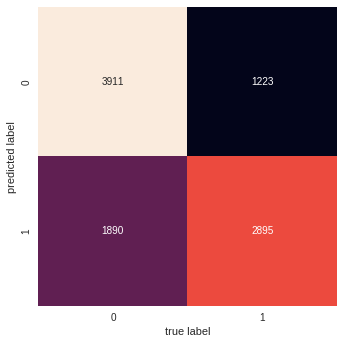

In [ ]:
# Get results

scores(preds_test,labels_test)

In [ ]:
import pickle

pickle.dump(preds_test, open('/content/bert_outputs', 'wb'))

In [ ]:
from sklearn.metrics import log_loss, roc_auc_score, roc_curve

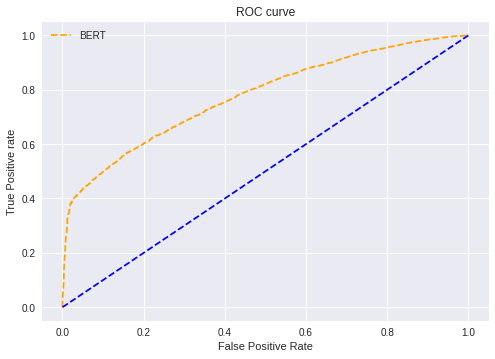

0.7762727474345624


In [ ]:

pred_prob1 = probs_test
fpr1, tpr1, thresh1 = roc_curve(labels_test, pred_prob1, pos_label=1)
random_probs = [0 for i in range(len(labels_test))]
p_fpr, p_tpr, _ = roc_curve(labels_test, random_probs, pos_label=1)
auc_score1 = roc_auc_score(labels_test, probs_test)
plt.style.use('seaborn')
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='BERT')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();
print(auc_score1)